In [2]:
import foolbox as fb
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Select device (GPU or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load ResNet50 pre-trained model and move it to the selected device
model = models.resnet50(pretrained=True).to(device)
model.eval()

# Convert to Foolbox model
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = fb.PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing, device=device)

# Load and preprocess an image
img_path = "room.jpg"
image = Image.open(img_path).convert("RGB")
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
img_tensor = transform(image).unsqueeze(0).to(device)  # Move input to device

# Get original prediction before the attack
with torch.no_grad():
    logits = model(img_tensor)  # Get logits
    original_label = logits.argmax(dim=1).item()  # Get predicted class
print(f"Original Prediction: {original_label}")

# Define label for attack (i.e., the original prediction)
label = torch.tensor([original_label]).to(device)

# Define the attack and criterion
attack = fb.attacks.FGSM()
criterion = fb.criteria.Misclassification(labels=label)

# Perform the attack
epsilon = 0.03  # Strength of perturbation
adversarial_image, perturbed_image, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=epsilon)
# print(img_tensor.shape)
print(adversarial_image.shape)
# Get new prediction after the attack
with torch.no_grad():
    logits_adv = model(adversarial_image)  # Get logits for adversarial image
    adversarial_label = logits_adv.argmax(dim=1).item()  # Get new predicted class
print(f"Adversarial Prediction: {adversarial_label}")

# # Check if attack was successful
# if adversarial_label != original_label:
#     print("Attack was successful! The model misclassified the adversarial example.")
# else:
#     print("Attack failed. The model still predicts the same class.")


Using device: cpu


C:\Users\Nitiw\anaconda3\envs\foolbox_evasion\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Nitiw\anaconda3\envs\foolbox_evasion\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original Prediction: 892
torch.Size([1, 3, 224, 224])
Adversarial Prediction: 669


In [10]:
import json
import urllib.request

# Load the ImageNet class labels (from ImageNet JSON file)
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
with urllib.request.urlopen(url) as f:
    class_idx = json.load(f)

# Map the class ID to the label
original_class = class_idx[str(original_label)][1]
adversarial_class = class_idx[str(adversarial_label)][1]

print(f"Original class (892): {original_class}")
print(f"Adversarial class (669): {adversarial_class}")

Original class (892): wall_clock
Adversarial class (669): mosquito_net


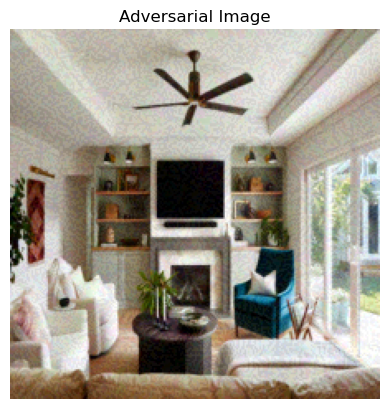

In [6]:
import matplotlib.pyplot as plt
import torch

# Check if perturbed_image is a tensor, convert if necessary
if not isinstance(perturbed_image, torch.Tensor):
    perturbed_image = torch.tensor(perturbed_image)

# Remove batch dimension if present (from (B, C, H, W) to (C, H, W))
if perturbed_image.dim() == 4:
    perturbed_image = perturbed_image.squeeze(0)  # Remove batch dimension

# Convert (C, H, W) -> (H, W, C) for visualization
adv_image_numpy = perturbed_image.permute(1, 2, 0).cpu().detach().numpy()

# Display the adversarial image
plt.imshow(adv_image_numpy)
plt.axis("off")
plt.title("Adversarial Image")
plt.show()
